# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_n_snps_used_and_sharing"
    / "gls-1000g_mashr-sub_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_sharing/gls-1000g_mashr-sub_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, check_n_lvs=True, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lvs = results["lv"].unique()
    n_observed_lvs = len(observed_lvs)
    if check_n_lvs:
        assert n_observed_lvs == 1
        observed_lv = observed_lvs[0]
    else:
        observed_lv = f"All LVs ({n_observed_lvs})"

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_sharing/gls-1000g_mashr-sub_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_sharing/gls-1000g_mashr-sub_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_sharing/gls-1000g_mashr-sub_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_sharing/gls-1000g_mashr-sub_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_and_sharing/gls-1000g_mashr-sub_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,-0.006270,0.011014,-0.569331,0.569151,0.715424,random.pheno988
1,LV2,0.026682,0.012456,2.142045,0.032227,0.016114,random.pheno988
2,LV3,-0.009844,0.012324,-0.798804,0.424434,0.787783,random.pheno988
3,LV4,-0.016282,0.011939,-1.363734,0.172699,0.913651,random.pheno988
4,LV5,0.004704,0.012747,0.369070,0.712087,0.356044,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.062239108409321175

# QQ-plot

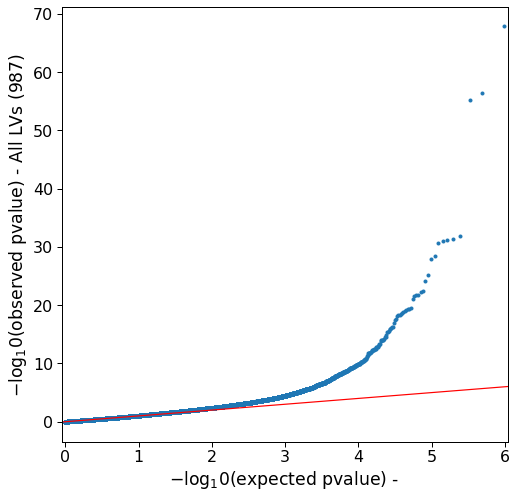

In [18]:
qqplot_unif(dfs, check_n_lvs=False)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.004,0.026,0.061
1,LV10,0.008,0.050,0.087
2,LV100,0.011,0.031,0.061
3,LV101,0.009,0.040,0.085
4,LV102,0.016,0.061,0.104


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.018280,0.062239,0.111088
std,0.018189,0.028708,0.036012
min,0.000000,0.000000,0.002000
25%,0.011000,0.047000,0.091000
50%,0.015000,0.059000,0.107000
75%,0.020000,0.070000,0.125000
max,0.253000,0.350000,0.412000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(63, 4)

,lv,1,5,10
462,LV515,0.013,0.049,0.084
507,LV556,0.012,0.049,0.090
395,LV455,0.011,0.049,0.087
394,LV454,0.014,0.049,0.098
379,LV440,0.002,0.049,0.084
377,LV439,0.013,0.049,0.098
529,LV576,0.014,0.049,0.097
326,LV393,0.009,0.049,0.099
298,LV368,0.010,0.049,0.083
750,LV775,0.011,0.049,0.102


,lv,1,5,10
12,LV11,0.010,0.051,0.092
84,LV175,0.010,0.051,0.099
825,LV842,0.011,0.051,0.094
146,LV230,0.015,0.051,0.084
779,LV800,0.010,0.051,0.094
182,LV263,0.012,0.051,0.111
253,LV327,0.014,0.051,0.086
724,LV751,0.015,0.051,0.099
470,LV522,0.015,0.051,0.095
308,LV377,0.014,0.051,0.089


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(450, 4)

,lv,1,5,10
431,LV488,0.081,0.153,0.217
906,LV915,0.093,0.163,0.214
129,LV215,0.080,0.169,0.234
153,LV237,0.089,0.176,0.249
349,LV413,0.103,0.177,0.231
255,LV329,0.133,0.183,0.212
401,LV460,0.112,0.193,0.255
682,LV713,0.103,0.193,0.248
965,LV969,0.119,0.200,0.266
423,LV480,0.100,0.200,0.294


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.017120,0.010311,1.660394,0.096884,0.048442,random.pheno988
1031,LV45,0.010816,0.010322,1.047911,0.294719,0.147360,random.pheno589
2018,LV45,0.005110,0.010318,0.495279,0.620420,0.310210,random.pheno385
3005,LV45,0.006117,0.010306,0.593517,0.552856,0.276428,random.pheno5
3992,LV45,-0.016303,0.010308,-1.581619,0.113786,0.943107,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.021

In [32]:
show_prop(results, 0.05)

0.064

In [33]:
show_prop(results, 0.10)

0.123

In [34]:
show_prop(results, 0.15)

0.164

In [35]:
show_prop(results, 0.20)

0.203

### QQplot

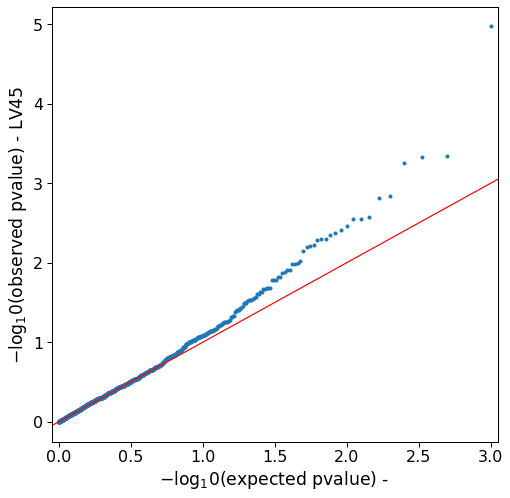

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.020138,0.012364,1.628749,0.103415,0.051708,random.pheno988
1220,LV234,0.000597,0.012349,0.048370,0.961423,0.480712,random.pheno589
2207,LV234,-0.012212,0.012341,-0.989591,0.322411,0.838794,random.pheno385
3194,LV234,0.010186,0.012338,0.825592,0.409066,0.204533,random.pheno5
4181,LV234,0.002599,0.012373,0.210031,0.833650,0.416825,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.018

In [43]:
show_prop(results, 0.05)

0.061

In [44]:
show_prop(results, 0.10)

0.12

In [45]:
show_prop(results, 0.15)

0.153

In [46]:
show_prop(results, 0.20)

0.18

### QQplot

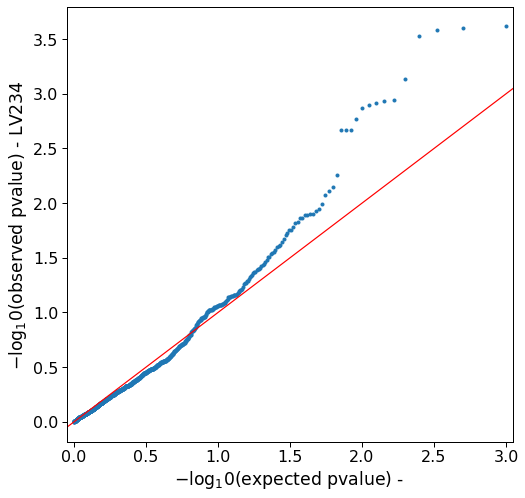

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,0.009993,0.012904,0.774387,0.438730,0.219365,random.pheno988
1833,LV847,0.003337,0.012932,0.258009,0.796408,0.398204,random.pheno589
2820,LV847,-0.014463,0.012912,-1.120130,0.262700,0.868650,random.pheno385
3807,LV847,0.008287,0.012895,0.642703,0.520440,0.260220,random.pheno5
4794,LV847,0.007553,0.012953,0.583088,0.559854,0.279927,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.025

In [54]:
show_prop(results, 0.05)

0.061

In [55]:
show_prop(results, 0.10)

0.103

In [56]:
show_prop(results, 0.15)

0.143

In [57]:
show_prop(results, 0.20)

0.185

### QQplot

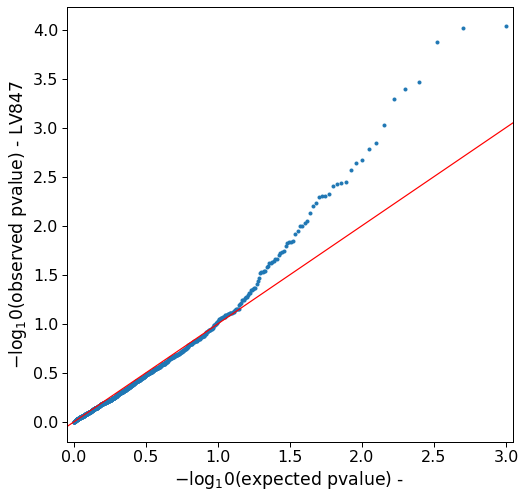

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.023358,0.013710,-1.703691,0.088487,0.955756,random.pheno988
1096,LV110,-0.009842,0.013725,-0.717061,0.473362,0.763319,random.pheno589
2083,LV110,-0.020694,0.013716,-1.508742,0.131414,0.934293,random.pheno385
3070,LV110,-0.008475,0.013676,-0.619662,0.535502,0.732249,random.pheno5
4057,LV110,-0.003984,0.013716,-0.290452,0.771480,0.614260,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.008

In [65]:
show_prop(results, 0.05)

0.034

In [66]:
show_prop(results, 0.10)

0.078

In [67]:
show_prop(results, 0.15)

0.11

In [68]:
show_prop(results, 0.20)

0.158

### QQplot

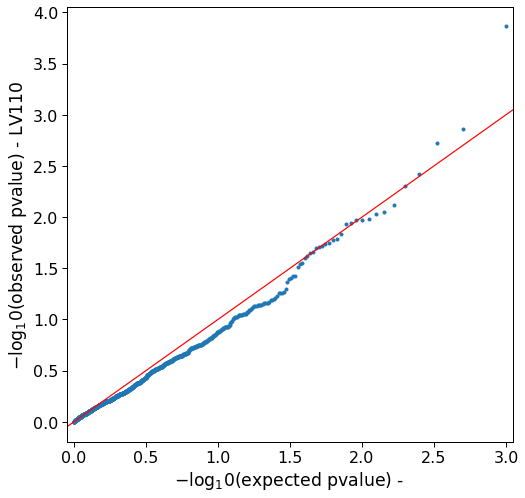

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.015794,0.011841,1.333866,0.182295,0.091147,random.pheno988
1755,LV769,0.002198,0.011809,0.186176,0.852312,0.426156,random.pheno589
2742,LV769,0.003043,0.011827,0.257338,0.796926,0.398463,random.pheno385
3729,LV769,-0.014446,0.011820,-1.222152,0.221695,0.889153,random.pheno5
4716,LV769,-0.019381,0.011847,-1.635983,0.101892,0.949054,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.054

In [76]:
show_prop(results, 0.05)

0.151

In [77]:
show_prop(results, 0.10)

0.23

In [78]:
show_prop(results, 0.15)

0.301

In [79]:
show_prop(results, 0.20)

0.359

### QQplot

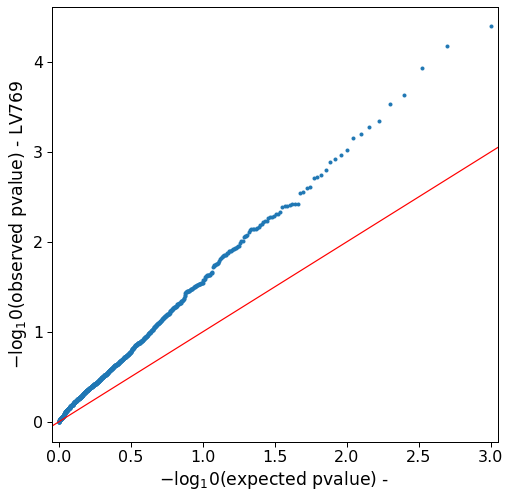

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.008286,0.014089,0.588143,0.556457,0.278228,random.pheno988
1786,LV800,-0.007040,0.014097,-0.499429,0.617494,0.691253,random.pheno589
2773,LV800,-0.003158,0.014118,-0.223712,0.822988,0.588506,random.pheno385
3760,LV800,-0.020485,0.014123,-1.450475,0.146975,0.926513,random.pheno5
4747,LV800,-0.012854,0.014066,-0.913839,0.360836,0.819582,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.01

In [87]:
show_prop(results, 0.05)

0.051

In [88]:
show_prop(results, 0.10)

0.094

In [89]:
show_prop(results, 0.15)

0.151

In [90]:
show_prop(results, 0.20)

0.192

### QQplot

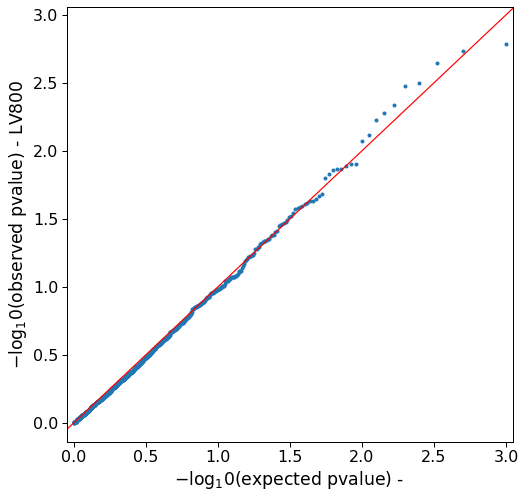

In [91]:
qqplot_unif(results)

# LVs with expected mean type I error

In [92]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
462,LV515,0.013,0.049,0.084
507,LV556,0.012,0.049,0.090
395,LV455,0.011,0.049,0.087
394,LV454,0.014,0.049,0.098
379,LV440,0.002,0.049,0.084
377,LV439,0.013,0.049,0.098
529,LV576,0.014,0.049,0.097
326,LV393,0.009,0.049,0.099
298,LV368,0.010,0.049,0.083
750,LV775,0.011,0.049,0.102


In [93]:
lv_results_expected = {}

## LV412

In [94]:
lv_code = "LV412"

In [95]:
results = dfs[dfs["lv"] == lv_code]

In [96]:
results.shape

(1000, 7)

In [97]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,0.005208,0.011379,0.457649,0.647220,0.323610,random.pheno988
1398,LV412,-0.004742,0.011331,-0.418511,0.675588,0.662206,random.pheno589
2385,LV412,0.006485,0.011326,0.572603,0.566933,0.283467,random.pheno385
3372,LV412,0.000720,0.011388,0.063226,0.949589,0.474794,random.pheno5
4359,LV412,0.008731,0.011330,0.770609,0.440967,0.220483,random.pheno74


In [98]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [99]:
show_prop(results, 0.01)

0.01

In [100]:
show_prop(results, 0.05)

0.053

In [101]:
show_prop(results, 0.10)

0.089

In [102]:
show_prop(results, 0.15)

0.133

In [103]:
show_prop(results, 0.20)

0.171

### QQplot

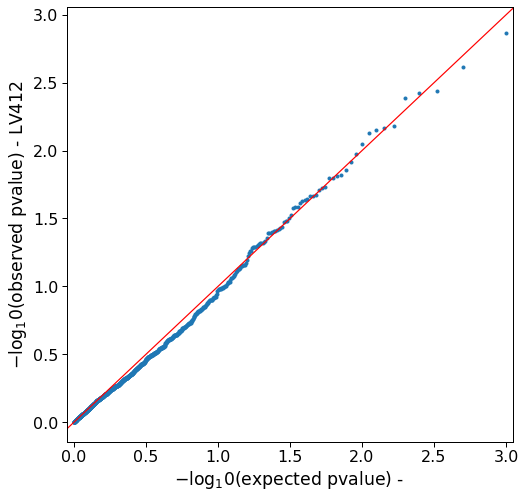

In [104]:
qqplot_unif(results)

## LV57

In [105]:
lv_code = "LV57"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.013225,0.012572,-1.051904,0.292883,0.853559,random.pheno988
1043,LV57,0.019281,0.012590,1.531400,0.125720,0.062860,random.pheno589
2030,LV57,0.017649,0.012597,1.401067,0.161242,0.080621,random.pheno385
3017,LV57,0.005956,0.012577,0.473531,0.635850,0.317925,random.pheno5
4004,LV57,0.011728,0.012557,0.934023,0.350327,0.175164,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.011

In [111]:
show_prop(results, 0.05)

0.054

In [112]:
show_prop(results, 0.10)

0.095

In [113]:
show_prop(results, 0.15)

0.139

In [114]:
show_prop(results, 0.20)

0.177

### QQplot

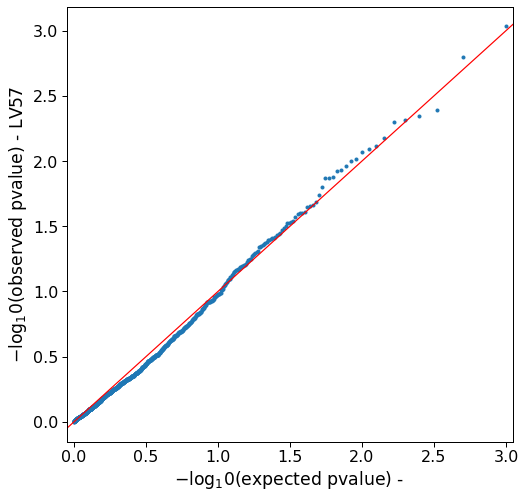

In [115]:
qqplot_unif(results)

## LV647

In [116]:
lv_code = "LV647"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.003484,0.011980,-0.290851,0.771175,0.614412,random.pheno988
1633,LV647,0.014856,0.011987,1.239378,0.215251,0.107625,random.pheno589
2620,LV647,0.008568,0.011986,0.714841,0.474733,0.237367,random.pheno385
3607,LV647,0.008039,0.011985,0.670729,0.502417,0.251209,random.pheno5
4594,LV647,0.010581,0.011957,0.884863,0.376264,0.188132,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.025

In [122]:
show_prop(results, 0.05)

0.072

In [123]:
show_prop(results, 0.10)

0.115

In [124]:
show_prop(results, 0.15)

0.147

In [125]:
show_prop(results, 0.20)

0.203

### QQplot

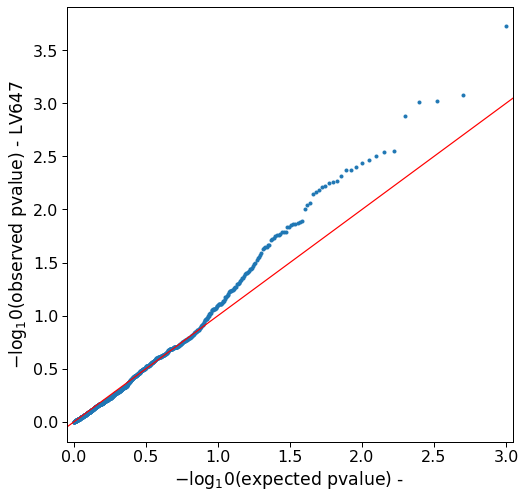

In [126]:
qqplot_unif(results)